In [2]:
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import RectangleSelector
import skimage.util
import scipy.ndimage as ndimage
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.io import imread
import matplotlib
import skimage.restoration as restoration

import skimage.filters.rank as rank
plt.gray()
def PSNR(f,g):
    return 10*np.log10(1.0/ np.mean(np.square(f-g)))


class Selector:
    def __init__(self, ax):
        self.RS = RectangleSelector(ax, self.line_select_callback,
                                     useblit=True,
                                       button=[1, 3],  
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)
        self.bbox = [None, None, None, None]
        
    def line_select_callback(self,eclick, erelease):
        'eclick and erelease are the press and release events'
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        self.bbox = [int(y1), int(y2), int(x1), int(x2)]
    def get_bbox(self):
        return self.bbox

f = imread('cameraman.tif').astype(np.float64)/255
I = imread('degraded.tif').astype(np.float64)/255


<Figure size 640x480 with 0 Axes>

0.031692677070828235 0.9166866746698679


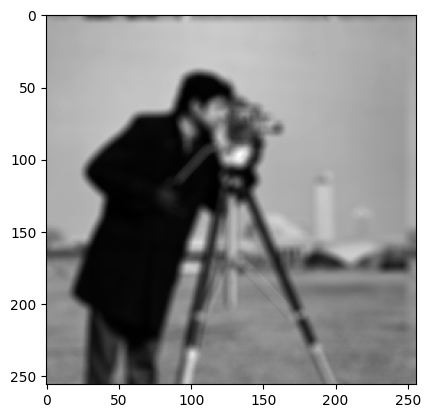

16.313347655863858


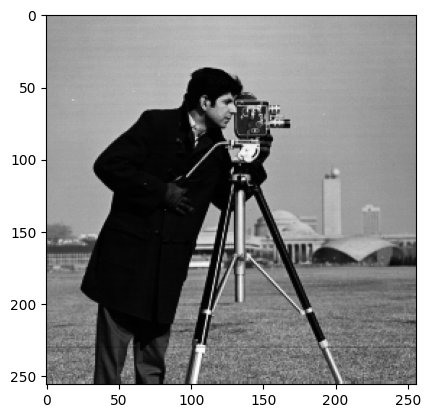

316.55451341786386


In [33]:
h_d = disk(4)
h = np.zeros((256,256))

h[0:9,0:9] = h_d
h = np.roll(h, (-5,-5)) / np.sum(h)
h_freq = np.fft.fft2(h)
f_blurfreq = h_freq*np.fft.fft2(f)
f_blur = np.real(np.fft.ifft2(f_blurfreq))

plt.imshow(f_blur)
print(f_blur.min(), f_blur.max())
plt.show()

def PSNR(f,g):
    return 10*np.log10(1.0/ np.mean(np.square(f-g)))

print(PSNR(f_blur,f))

plt.imshow(abs(np.fft.ifft2(f_blurfreq/h_freq)))
plt.show()
print(PSNR(abs(np.fft.ifft2(f_blurfreq/h_freq)), f))

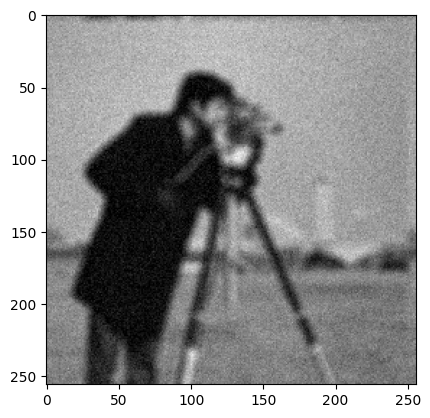

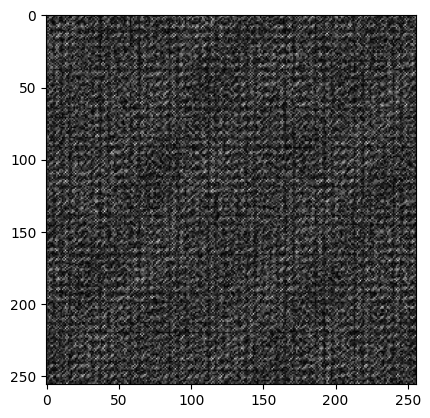

-40.941559553561994


In [4]:
noisyblur = skimage.util.random_noise(f_blur, mode='gaussian', var=0.002)

plt.imshow(noisyblur)   
plt.show()
gaussfreq = np.fft.fft2(noisyblur)
nbfiltered = abs(np.fft.ifft2(gaussfreq/h_freq))
plt.imshow(nbfiltered)
plt.show()

print(PSNR(nbfiltered, f))

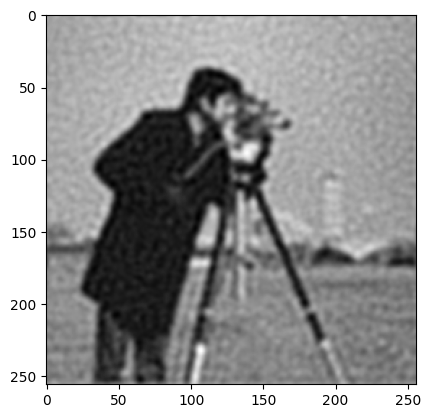

22.69718198226915


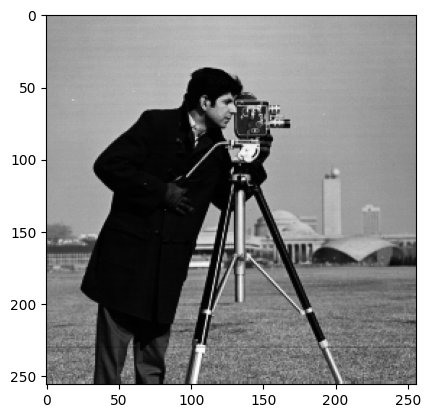

In [34]:
restored = skimage.restoration.wiener(noisyblur, np.fft.fftshift(h), 0.1)
plt.imshow(restored)
plt.show()
print(PSNR(restored, f))
plt.imshow(f)
plt.show()


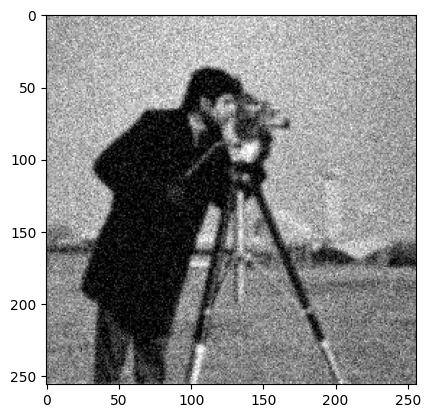

In [6]:
plt.imshow(I)
plt.show()

In [20]:
K = [8, 61, 174, 246]
mn = np.ones((5,5))/25
local_mean = signal.convolve(I, mn, mode='same')
local_var = signal.convolve(I**2, mn, mode='same') - local_mean**2


In [ ]:
class Selector:
    def __init__(self, ax):
        self.RS = RectangleSelector(ax, self.line_select_callback,
                                     useblit=True,
                                       button=[1, 3],  
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)
        self.bbox = [None, None, None, None]
        
    def line_select_callback(self,eclick, erelease):
        'eclick and erelease are the press and release events'
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        self.bbox = [int(y1), int(y2), int(x1), int(x2)]
    def get_bbox(self):
        return self.bbox


0.010685871646598424


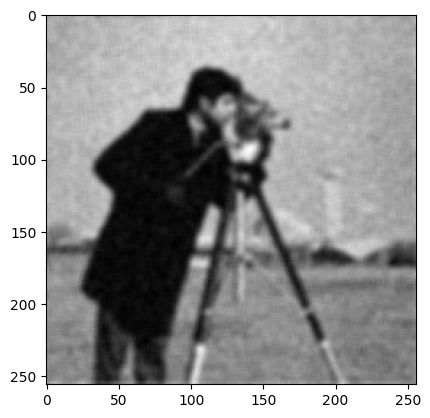

21.842695302843175


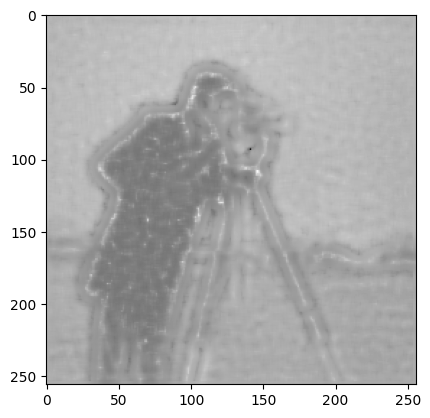

15.918244375840558


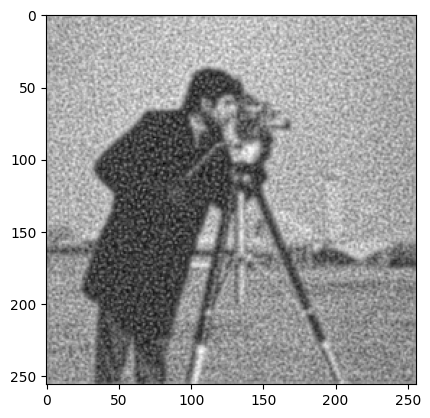

18.50232980604152


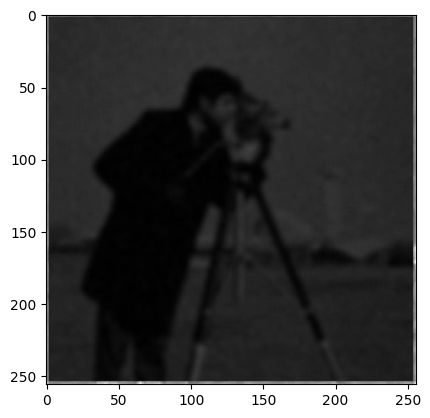

11.140346221719913


In [31]:
noisevar = np.var(I[K[0]:K[1], K[2]:K[3]])  
print(noisevar)


def lee_filter(img, size):
    img_mean = ndimage.uniform_filter(img, (size, size))
    img_sqr_mean = ndimage.uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    mn = np.ones((5,5))/25
    local_mean = signal.convolve(I, mn, mode='same')
    local_var = signal.convolve(I**2, mn, mode='same') - local_mean**2

    img_weights =  (local_var + noisevar) /local_var 
    img_output = img_weights*img_mean + (1 -img_weights) * local_mean
    return img_output

filtered = lee_filter(I, 5)
plt.imshow(filtered)
plt.show()
print(PSNR(filtered, f))

filtered2 = lee_filter(I, 15)
plt.imshow(filtered2)
plt.show()
print(PSNR(filtered2, f))

filtered3 = lee_filter(I, 2)
plt.imshow(filtered3)
plt.show()
print(PSNR(filtered3, f))

def lee_filter2(img, size):
    img_mean = ndimage.uniform_filter(img, (size, size))
    img_sqr_mean = ndimage.uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    mn = np.ones((5,5))/25
    local_mean = signal.convolve(I, mn, mode='same')
    local_var = signal.convolve(I**2, mn, mode='same') - local_mean**2

    img_weights =  (local_var + 0.6) /local_var 
    img_output = img_weights*img_mean + (1 -img_weights) * local_mean
    return img_output

filtered4 = lee_filter2(I, 5)
plt.imshow(filtered4)
plt.show()
print(PSNR(filtered4, I))


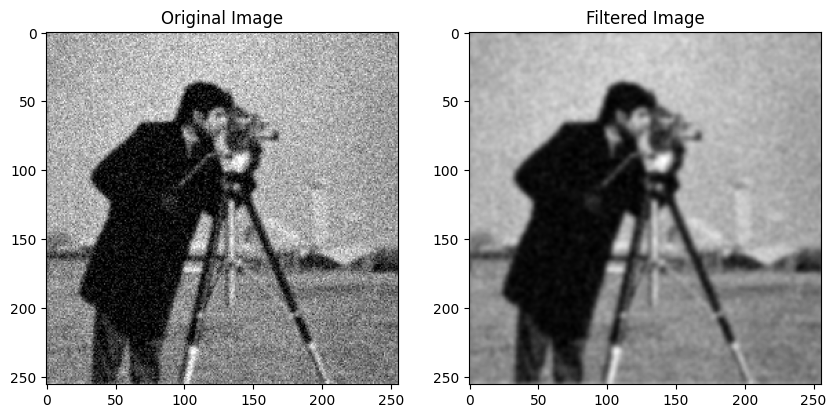

20.833019866232362


In [ ]:
from scipy.ndimage import gaussian_filter


def gaussian_low_pass_filter(shape, sigma):
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    y, x = np.ogrid[:rows, :cols]
    distance = (x - center_col) ** 2 + (y - center_row) ** 2
    gaussian_filter = np.exp(-distance / (2 * (sigma ** 2)))
    return gaussian_filter


dft = np.fft.fft2(I)
dft_shift = np.fft.fftshift(dft)

sigma = 30
gaussian_filter = gaussian_low_pass_filter(I.shape, sigma)

# Compare with Gaussian filter
filtered_dft_shift = dft_shift * gaussian_filter

filtered_dft = np.fft.ifftshift(filtered_dft_shift)
filtered_image = np.fft.ifft2(filtered_dft)
filtered_image = np.abs(filtered_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(I, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Filtered Image")
plt.imshow(filtered_image, cmap="gray")

plt.show()

print(PSNR(filtered_image, I))